In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Simulador de monitoramento para decisão de troca de perfil


## Tarefas


- [X] obter descrição dos algoritmos utilizados pelo trabalho base.
- [X] verificar se em situações descritas no trabalho base, os algoritmos apresentam os resultados esperados
- [X] carregar algoritmos de previsão desenvolvidos.
- [ ] carregar os dados separados para teste
- [ ] executar algoritmos de detecção/previsão de tendência
- [ ] montar gráficos com os resultados
- [ ] executar algoritmos de detecção/previsão de perfil
- [ ] montar gráficos com os resultados
- [ ] calcular e apresentar métricas de comparação entre as abordagens de detecção e previsão


## Notas

In [2]:
# (oliveira2016, p. 109) TAB. 6.2: Valores para identificação de perfil de tarefas
MB = 1024 ** 2
CONFIG = {
    'cpu': {'threshold': 90, 'hold_on': 5, 'instantly_notify': False},
    'memory': {'threshold': 90, 'hold_on': 0, 'instantly_notify': True},
    'io': {'threshold': 20 * MB, 'hold_on': 25, 'instantly_notify': True}
}

Flags do threshold analyzer:
- **key**: nome do recurso monitorado (CPU, Memory, I/O)
- **threshold**: limite a partir do qual o recursos começa a ser degradado pela concor-rência entre as tarefas
- **hold_on**: número de coletas antes de afirmar a troca do perfil da aplicação e notificar o escalonador
- **instantly_notify**: flag utilizada para notificar o servidor assim que o valor coletado ultrapassar o threshold. Diferentemente de setar o hold_on para 0, com esta variável, o monitor espera para alterar o perfil quando o valor está abaixo do limite.

In [3]:
# Messagem enviada ao escalonador quando detectado
[
    {"resource": "cpu", "start": True},
    {"resource": "io", "end": True}
];

EMA/MME (oliveira2016, p. 52)

FIG. 4.9: Perfil do Workflow de Aplicações Sintéticas p. 56

## Imports

In [4]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
class Requests:
    def delete(self, *args, **kwargs):
        print('delete', args, kwargs)
    def patch(self, *args, **kwargs):
        print('patch', args, kwargs)

requests = Requests()

## Calcular tendência

In [6]:
class EMAModel:

    def __init__(self, resource, n=10):
        self.resource = resource
        self.alpha = 2 / (n + 1)
        self.ema = None

    def predict(self, data):
        x = data[self.resource]
        self.ema = (x if self.ema is None
                    else x * self.alpha + self.ema * (1 - self.alpha))
        return self.ema

In [7]:
def features_order(resources, windows=3):
    features = ['%s-1' % r for r in resources]
    features.extend(['%s-diff-%d' % (r, d)
                    for r in resources
                    for d in reversed(range(1, 1 + windows))])
    return features

features_order(['cpu', 'io_total'])

['cpu-1',
 'io_total-1',
 'cpu-diff-3',
 'cpu-diff-2',
 'cpu-diff-1',
 'io_total-diff-3',
 'io_total-diff-2',
 'io_total-diff-1']

In [8]:
class VotesModel:

    def __init__(self, models, resources, num_deltas, target, threshold):
        self.models = models
        self.resources = resources
        self.num_deltas = num_deltas
        self.num_windows = num_deltas + 1
        self.data = pd.DataFrame(columns=resources)
        self.target = target
        self.threshold = threshold

    def update(self, data):
        """Update historic data."""
        data = {k: v for (k, v) in data.items() if k in self.resources}
        self.data = self.data.append(data, ignore_index=True)
        if len(self.data) > self.num_windows:
            self.data.drop(index=self.data.index[0], inplace=True)

    @property
    def state(self):
        """
        Calculate derived attributes and return the input (X) for ML
        algorithms.
        """
        if self.data.empty:
            return None
        diff = self.data.diff().dropna()
        last = self.data.iloc[-1]
        state = []
        for r in self.resources:
            state.append(last[r])
        for r in self.resources:
            state.extend(diff.iloc[-self.num_deltas:][r].values)
            # for i in reversed(range(1, 1 + self.num_deltas)):
            #     state.append(diff.iloc[-i][r])
        return state

    def predict(self, data):
        self.update(data)
        if len(self.data) < self.num_windows:
            return None
        if data[self.target] < self.threshold:
            return None
        X = [self.state]
        return [bool(model.predict(X)) for model in self.models]

In [9]:
class Predictor:

    def __init__(self, models=None):
        self.models = models
        if models is None:
            self.models = {}

    def add_model(self, resource, model):
        self.models[resource] = model

    def predict(self, data):
        """
        Predicts resource usage increase/decrease.
        """
        return {r: self.models[r].predict(data) for r in data.keys()}

## Troca de perfil

In [10]:
class ThresholdRule:
    """
    Decides if resorce usage is increasing based on a threshold.

    :param threshold: value that defines behavior changes
    :param hold_on: skip collects before inform behavior update
    :param instantly_notify: notify when the collected value is above the
    threshold. Not the same as hold_on=0! instantly_notify make the monitor
    waits when the collected value is below the threshold.
    """

    def __init__(self, threshold, hold_on, instantly_notify=False):
        self.threshold = threshold
        self.hold_on = hold_on
        self.waiting = 0
        self.applied = False
        self.instantly_notify = instantly_notify

    def apply(self, value):
        if value < self.threshold:
            if self.waiting != 0:
                self.waiting -= 1
                return self.applied
            self.applied = False
        else:
            if self.instantly_notify:
                self.applied = True
                self.waiting = self.hold_on
                return self.applied
            if self.waiting != self.hold_on:
                self.waiting += 1
                return self.applied
            self.applied = True
        return self.applied

In [11]:
class ElectionRule:

    def __init__(self, weights=None, hold_on=5, instantly_notify=False):
        self.weights = weights
        self.hold_on = hold_on
        self.waiting = 0
        self.applied = False
        self.instantly_notify = instantly_notify

    def apply(self, votes):
        """
        Returns True if the majority of the weighted votes are True.
        Ties are False.

            >>> r = ElectionRule() # same weight
            >>> r.apply([1, 0, 1, 0])
            False
            >>> r.apply([1, 0, 1, 1])
            True
            >>> r.apply(None)
            False
            >>> r = ElectionRule([2, 1, 1, 1])
            >>> r.apply([1, 0, 1, 0])
            True
        """
        if votes is None:
            return False
        W  = (self.weights if self.weights is not None else [1] * len(votes))
        h = (2/3) * sum(W)
        count = sum([v * w for (v, w) in zip(votes, W)])
        return count >= h

In [ ]:


# if count < h:
#     if self.waiting != 0:
#         self.waiting -= 1
#         return self.applied
#     self.applied = False
# else:
#     if self.instantly_notify:
#         self.applied = True
#         self.waiting = self.hold_on
#         return self.applied
#     if self.waiting != self.hold_on:
#         self.waiting += 1
#         return self.applied
#     self.applied = True
# return self.applied

In [29]:
class FixedElectionRule:

    def __init__(self, *args, **kwargs):
        self.activated = False
        self.counter = 0

    def apply(self, votes):
        if votes is None:
            return False
        election = any([
            all(votes)
            #, all([votes[0], votes[1], votes[2]])
            #, all([votes[1], votes[2], votes[3]])
        ])
        if not self.activated and election:
            self.counter = 0
            self.activated = True
        elif self.activated and not election and self.counter < 5:
            self.counter += 1
        elif self.activated and not election and self.counter >= 5:
            self.counter = 0
            self.activated = False
        return self.activated

In [13]:
class Analyzer:
    """
    Decides which resource uses which rule.
    """
    def __init__(self, rules=None):
        self.rules = rules
        if rules is None:
            self.rules = {}
    
    def add_rule(self, resource, rule):
        self.rules[resource] = rule

    def behavior(self, data):
        """
        Inform behavior based on added rules

        :param data: collected data to analyze

        Returns a dict with True (if behavior changes to intensive)
        or False (if not) for each collect data in data
        """
        return {r: self.rules[r].apply(v) for (r, v) in data.items()}

In [ ]:
class GuessModel:

    def __init__(self, guess):
        self.guess = guess

    def predict(self, *_):
        return self.guess


def test_votes_predictor():
    models = [GuessModel(1), GuessModel(1), GuessModel(0), GuessModel(0)]
    resources = ['x', 'y']
    votes_model = VotesModel(models, resources, num_deltas=3, target='x', threshold=0)
    predictor = Predictor({'x': votes_model, 'y': GuessModel(42)})
    data = [{'x': 20, 'y': 10}] * 10
    return [(d, predictor.predict(d)) for d in data]


#pprint(test_votes_predictor())


def test_election_analyzer():
    resources = ['x']
    data = [{'x': i} for i in [1,2,3,4,5,2,4,6,8,10]]
    ml_models = [GuessModel(i) for i in [1, 0, 0, 1]]
    # Combine each  model
    votes_model = VotesModel(ml_models, resources, num_deltas=3, target='x', threshold=0)
    # Decides which resource uses which model
    predictor = Predictor({'x': votes_model})
    predictions = [predictor.predict(d) for d in data]
    # Our heuristics
    election_rule = ElectionRule([4,3,2,1])
    # Decides which resources uses which heuristics
    analyzer = Analyzer({'x': election_rule})
    behavior = [analyzer.behavior(p) for p in predictions]
    return [(d, p, b) for (d, p, b) in zip(data, predictions, behavior)]


pprint(test_election_analyzer())

[({'x': 1}, {'x': None}, {'x': False}),
 ({'x': 2}, {'x': None}, {'x': False}),
 ({'x': 3}, {'x': None}, {'x': False}),
 ({'x': 4}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 5}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 2}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 4}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 6}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 8}, {'x': [True, False, False, True]}, {'x': False}),
 ({'x': 10}, {'x': [True, False, False, True]}, {'x': False})]


## Notificação de troca de perfil

In [14]:
class SynSchedNotifier:
    """
    Request to remote synsched server

    :param server_url: string remote address
    :param content_type: string header
    """
    def __init__(self, url, job_id, content_type='application/json'):
        self.url = url.format(job_id)
        self.headers = {'Content-Type': content_type}

    def changes(self, behavior_changes, step=None):
        """
        Send data to server if behavior has changed

        :param behavior_changes: set tuples (DictItem like) of behaviors changes

        Returns response
        """
        profile = []
        for (resource, flag) in behavior_changes:
            operation = 'start' if flag else 'end'
            profile.append({'resource': resource, operation: True})
        return requests.patch(self.url, data=json.dumps(profile),
                              headers=self.headers)

    def terminate(self):
        """
        Send a terminate signal to server

        Returns response
        """
        return requests.delete(self.url, headers=self.headers)

In [15]:
class StoreNotifier:
    def __init__(self):
        self.notifications = []

    def changes(self, changes, step=None):
        self.notifications.append(('changes', changes, step))

    def terminate(self):
        self.notifications.append(('terminate',))

## Coleta de dados

In [16]:
class FileCollector:

    def __init__(self, filename, cols=None, rename=None):
        self.df = pd.read_csv(filename)
        if rename is not None:
            self.df.rename(columns=rename, inplace=True)
        self.cols = cols
        self.row_index = 0
        self.num_rows = self.df.shape[0]

    def collect(self):
        if self.row_index >= self.num_rows:
            return None
        if self.cols is None:
            row = self.df.loc[self.row_index]
        else:
            row = self.df.loc[self.row_index, self.cols]
        self.row_index += 1
        return row.to_dict()

## Monitoramento

In [17]:
class Monitor:

    def __init__(self, collector, analyzer, predictor, notifier):
        self.collector = collector
        self.analyzer = analyzer
        self.predictor = predictor
        self.notifier = notifier
        self.cached_behavior = None

    def behavior(self, data):
        data = self.predictor.predict(data)
        return self.analyzer.behavior(data)

    def run(self):
        step = 0
        data = self.collector.collect()
        while data is not None:
            behavior = self.behavior(data)
            if self.cached_behavior is None:
                self.cached_behavior = behavior
                continue
            behavior_changes = behavior.items() - self.cached_behavior.items()
            if behavior_changes:
                self.notifier.changes(behavior_changes, step=step)
            self.cached_behavior = behavior
            data = self.collector.collect()
            step += 1
        self.notifier.terminate()

## Gráficos

In [18]:
def plot_notifications(notifications, data, figsize=(10, 4), styles=None, config=None):
    if styles is None:
        styles = {
            ('cpu',       True): ('tab:blue',   'dashed'),
            ('cpu',      False): ('tab:blue',   'solid'),
            ('memory',    True): ('tab:orange', 'dashed'),
            ('memory',   False): ('tab:orange', 'solid'),
            ('io_total',  True): ('tab:green',  'dashed'),
            ('io_total', False): ('tab:green',  'solid'),
        }
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    # plot usage data
    data.plot(y='cpu', color='tab:blue', ax=ax1)
    if '%memory' in data.columns:
        data.plot(y='%memory', color='tab:orange', ax=ax1)
    data.plot(y='io_total', color='tab:green', ax=ax2)
    # plot changes begin/end
    changes = [(*c, v[1], *styles[c])
               for (k, *v) in notifications if k == 'changes'
               for c in v[0]]
    ax1.vlines(x=[c[2] for c in changes], ymin=0, ymax=max(ax1.get_ylim()),
               colors=[c[3] for c in changes],
               linestyles=[c[4] for c in changes])
    ax2.vlines(x=[c[2] for c in changes], ymin=0, ymax=max(ax2.get_ylim()),
               colors=[c[3] for c in changes],
               linestyles=[c[4] for c in changes])
    # plot threshold
    if config is not None:
        ax1.hlines(y=config['cpu']['threshold'], xmin=0, xmax=len(data),
                    label="CPU threshold", colors='tab:blue', linestyles='dotted')
        ax1.hlines(y=config['memory']['threshold'], xmin=0, xmax=len(data),
                    label="Memory threshold", colors='tab:orange', linestyles='dotted')
        ax2.hlines(y=config['io']['threshold'], xmin=0, xmax=len(data),
                    label="IO threshold", colors='tab:green', linestyles='dotted')
    plt.legend()
    return fig

## Simulação

### Validação do algoritmo de detecção de troca de perfil com EMA com aplicação sintética

In [ ]:
CONFIG

{'cpu': {'hold_on': 5, 'instantly_notify': False, 'threshold': 90},
 'io': {'hold_on': 25, 'instantly_notify': True, 'threshold': 20971520},
 'memory': {'hold_on': 0, 'instantly_notify': True, 'threshold': 90}}

In [ ]:
sintetico = '/content/drive/MyDrive/ime/allan-matheus-mestrado/data/Projeto Graficos em R/csv/workflow-apps-sinteticos.csv'
total_memory =  18

ema = {'cpu': EMAModel('cpu'),
       'memory': EMAModel('memory'),
       'io_total': EMAModel('io_total')}

threshold = {'cpu': ThresholdRule(**CONFIG['cpu']),
             'memory': ThresholdRule(CONFIG['memory']['threshold'] * total_memory / 100,
                                     CONFIG['memory']['hold_on'],
                                     CONFIG['memory']['instantly_notify']),
             'io_total': ThresholdRule(**CONFIG['io'])}

ema_sin_notifier = StoreNotifier()

sin_collector = FileCollector(filename=sintetico, cols=['cpu', 'memory', 'io_total'],
                              rename={'CPU': 'cpu', 'Memory': 'memory', 'I/O Total': 'io_total'})

Monitor(sin_collector,
        Analyzer(threshold),
        Predictor(ema),
        ema_sin_notifier).run()

ema_sin_notifier.notifications

[('changes', {('cpu', True)}, 17),
 ('changes', {('io_total', True)}, 62),
 ('changes', {('cpu', False)}, 64),
 ('changes', {('cpu', True), ('memory', True)}, 225),
 ('changes', {('io_total', False)}, 247),
 ('changes', {('cpu', False)}, 258),
 ('terminate',)]

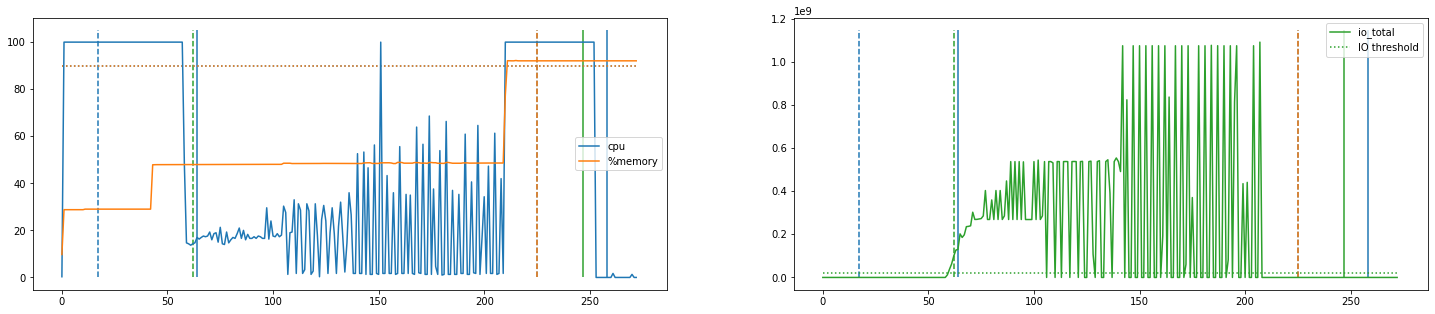

In [ ]:
# convert memory to % for plotting
sin_collector.df['%memory'] = 100 * sin_collector.df['memory'] / total_memory

plot_notifications(ema_sin_notifier.notifications, sin_collector.df, figsize=(25, 5), config=CONFIG);

### Algoritmos com previsão

In [19]:
blast = '/content/drive/MyDrive/ime/csv-data-2019-12-05/std-blast-instance-00000336-5deb0df01b1d9b3336951805.out.monitor.csv'
montage = '/content/drive/MyDrive/ime/csv-data-2019-12-05/std-montage-instance-000002ea-5de8d1861b1d9b333695176d.out.monitor.csv'

In [20]:
MODELS_PATH = '/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new'

montage_io_model_names = [
    'montage_io_RFC.joblib',
    'montage_io+20_MLPC.joblib',
    'montage_io+100_RFC.joblib',
    'montage_io+200_MLPC.joblib',
]
montage_cpu_model_names = [
    'montage_cpu_RFC.joblib',
    'montage_cpu+20_MLPC.joblib',
    'montage_cpu+100_MLPC.joblib',
    'montage_cpu+200_RFC.joblib',
]
montage_io_models = [joblib.load(f'{MODELS_PATH}/{model}') for model in montage_io_model_names]
montage_cpu_models = [joblib.load(f'{MODELS_PATH}/{model}') for model in montage_cpu_model_names]

blast_io_model_names = [
    'blast_io_RFC.joblib',
    'blast_io+20_MLPC.joblib',
    'blast_io+100_RFC.joblib',
    'blast_io+200_RFC.joblib',
]
blast_cpu_model_names = [
    'blast_cpu_MLPC.joblib',
    'blast_cpu+20_ABC.joblib',
    'blast_cpu+100_ABC.joblib',
    'blast_cpu+200_ABC.joblib',
]
blast_io_models = [joblib.load(f'{MODELS_PATH}/{model}') for model in blast_io_model_names]
blast_cpu_models = [joblib.load(f'{MODELS_PATH}/{model}') for model in blast_cpu_model_names]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or

In [30]:
models = {# 'cpu': EMAModel('cpu'),
          # 'io_total': EMAModel('io_total'),
          'cpu': VotesModel(models=blast_cpu_models,
                            resources=['cpu', 'io_total'],
                            num_deltas=3, target='cpu',
                            threshold=CONFIG['cpu']['threshold']),
          'io_total': VotesModel(models=blast_io_models,
                                 resources=['cpu', 'io_total'],
                                 num_deltas=3, target='io_total',
                                 threshold=CONFIG['io']['threshold']),
}

rules = {# 'cpu': ThresholdRule(**CONFIG['cpu']),
         # 'io_total': ThresholdRule(**CONFIG['io']),
         'cpu': FixedElectionRule(weights=[1.3, 1.2, 1.1, 1]),
         'io_total': FixedElectionRule(weights=[1.3, 1.2, 1.1, 1]),
}

notifier = StoreNotifier()
collector = FileCollector(filename=blast, cols=['cpu', 'io_total'])

Monitor(collector,
        Analyzer(rules),
        Predictor(models),
        notifier).run()

notifier.notifications

[('changes', {('cpu', True)}, 96),
 ('changes', {('cpu', False)}, 97),
 ('changes', {('cpu', True)}, 99),
 ('changes', {('cpu', False)}, 451),
 ('changes', {('cpu', True)}, 452),
 ('changes', {('cpu', False)}, 454),
 ('changes', {('cpu', True)}, 456),
 ('changes', {('cpu', False)}, 749),
 ('changes', {('cpu', True)}, 751),
 ('changes', {('cpu', False)}, 1438),
 ('changes', {('cpu', True)}, 1439),
 ('changes', {('cpu', False)}, 2841),
 ('changes', {('cpu', True)}, 3222),
 ('changes', {('cpu', False)}, 3223),
 ('changes', {('cpu', True)}, 3227),
 ('changes', {('cpu', False)}, 3235),
 ('changes', {('cpu', True)}, 3237),
 ('changes', {('cpu', False)}, 4763),
 ('changes', {('cpu', True)}, 4764),
 ('changes', {('cpu', False)}, 5033),
 ('changes', {('cpu', True)}, 5035),
 ('changes', {('cpu', False)}, 5736),
 ('changes', {('cpu', True)}, 6029),
 ('changes', {('cpu', False)}, 6031),
 ('changes', {('cpu', True)}, 6034),
 ('changes', {('cpu', False)}, 6402),
 ('changes', {('cpu', True)}, 6410),


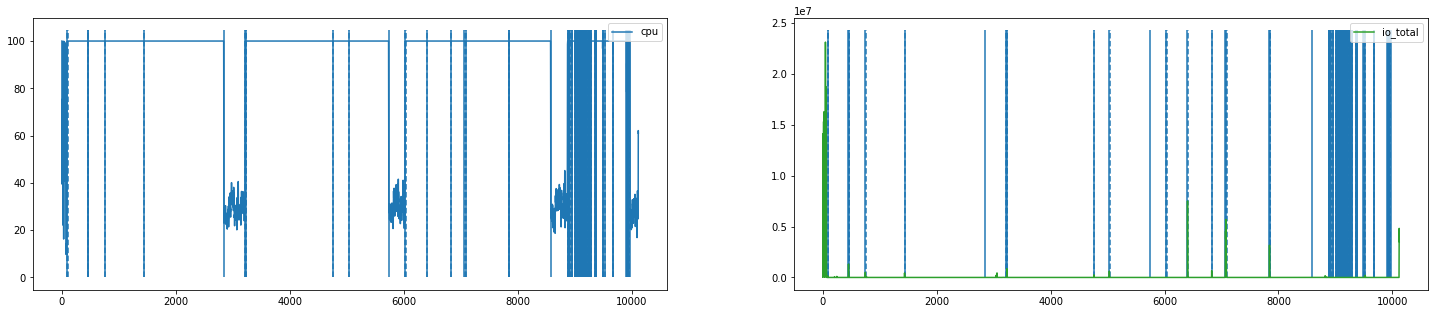

In [31]:
plot_notifications(notifier.notifications, collector.df, figsize=(25, 5));

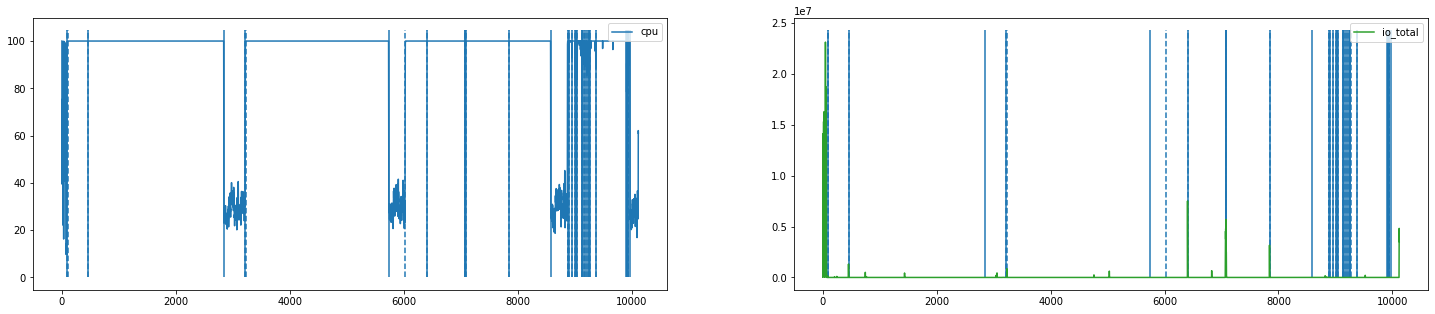

In [22]:
plot_notifications(notifier.notifications, collector.df, figsize=(25, 5));

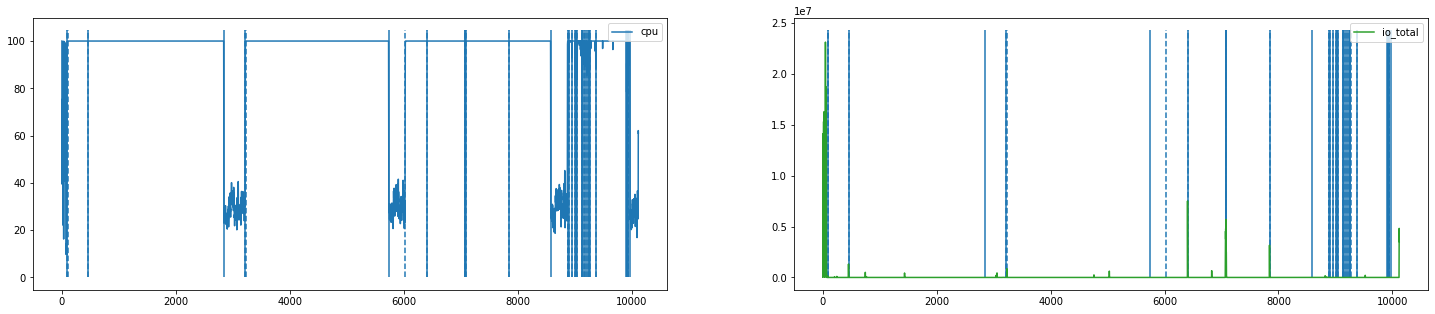

In [ ]:
plot_notifications(notifier.notifications, collector.df, figsize=(25, 5));

sem previsão
```
[('changes', {('io_total', True)}, 119),
 ('changes', {('cpu', True)}, 193),
 ('changes', {('cpu', False)}, 214),
 ('changes', {('cpu', True)}, 233),
 ('changes', {('cpu', False)}, 253),
 ('changes', {('io_total', False)}, 419),
 ('changes', {('io_total', True)}, 425),
 ('changes', {('io_total', False)}, 451),
 ('terminate',)]
``` 

com previsão (>2/3)
```
[('changes', {('io_total', True)}, 7),
 ('changes', {('io_total', False)}, 53),
 ('changes', {('io_total', True)}, 54),
 ('changes', {('io_total', False)}, 175),
 ('changes', {('io_total', True)}, 178),
 ('changes', {('io_total', False)}, 189),
 ('changes', {('cpu', True)}, 193),
 ('changes', {('io_total', True)}, 198),
 ('changes', {('cpu', False)}, 214),
 ('changes', {('io_total', False)}, 227),
 ('changes', {('cpu', True)}, 233),
 ('changes', {('io_total', True)}, 236),
 ('changes', {('cpu', False)}, 253),
 ('changes', {('io_total', False)}, 271),
 ('changes', {('io_total', True)}, 277),
 ('changes', {('io_total', False)}, 379),
 ('changes', {('io_total', True)}, 381),
 ('changes', {('io_total', False)}, 451),
 ('changes', {('io_total', True)}, 454),
 ('changes', {('io_total', False)}, 532),
 ('changes', {('io_total', True)}, 536),
 ('changes', {('io_total', False)}, 554),
 ('changes', {('io_total', True)}, 555),
 ('changes', {('io_total', False)}, 707),
 ('changes', {('io_total', True)}, 711),
 ('changes', {('io_total', False)}, 776),
 ('changes', {('io_total', True)}, 785),
 ('changes', {('io_total', False)}, 796),
 ('changes', {('io_total', True)}, 802),
 ('terminate',)]
```

com previsão
```
[('changes', {('io_total', True)}, 2),
 ('changes', {('io_total', False)}, 189),
 ('changes', {('cpu', True)}, 193),
 ('changes', {('io_total', True)}, 198),
 ('changes', {('cpu', False)}, 214),
 ('changes', {('io_total', False)}, 231),
 ('changes', {('cpu', True)}, 233),
 ('changes', {('io_total', True)}, 236),
 ('changes', {('cpu', False)}, 253),
 ('terminate',)]
```

---